# FROMAGe Inference Example

This is a notebook showcasing how to run some of the tasks that FROMAGe is capable of. It reproduces several examples in our paper, [Grounding Language Models to Images for Multimodal Generation](https://arxiv.org/abs/2301.13823).

For reproducibility, all examples in this notebook use greedy (deterministic) decoding. However, it is possible to change to nucleus sampling for more diverse and higher quality outputs (used for some of the figures in the paper) by changing the `temperature` and `top_p` in the `generate()` function.

At least 18GB of GPU memory is required to run this model (OPT-6.7B takes up a bit of memory), and it has only been tested on A6000, V100, and 3090 GPUs.

In [ ]:
import os
import sys
if not os.path.exists("/content/fromage"):# если еще не клонировали
  !git clone https://github.com/kohjingyu/fromage.git
  !pip install -r fromage/requirements.txt
  !pip install gdown
  !gdown --id 1wMojZNqEwApNlsCZVvSgQVtZLgbeLoKi -O /content/fromage/fromage_model/cc3m_embeddings.pkl

if not '/content/fromage' in sys.path:
  sys.path.append('/content/fromage')

#...
#model_dir = '/content/fromage/fromage_model'
#model = models.load_fromage(model_dir)

Cloning into 'fromage'...
remote: Enumerating objects: 181, done.
remote: Counting objects: 100% (88/88), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 181 (delta 62), reused 68 (delta 48), pack-reused 93
Receiving objects: 100% (181/181), 40.90 MiB | 11.31 MiB/s, done.
Resolving deltas: 100% (96/96), done.
  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /tmp/pip-req-build-00qtukn9
  Running command git clone --filter=blob:none --quiet https://github.com/ildoonet/pytorch-gradual-warmup-lr.git /tmp/pip-req-build-00qtukn9
  Resolved https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to commit 6b5e8953a80aef5b324104dc0c2e9b8c34d622bd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.3/155.3 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.8/198.8 kB 23.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 69.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 76.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 37.2 MB/s eta 0:00:00


In [ ]:
!pip install einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
import numpy as np
import copy
import torch
from transformers import logging
logging.set_verbosity_error()

from PIL import Image
!pip install matplotlib
import matplotlib.pyplot as plt

from fromage import models
from fromage import utils

Define some helper methods for displaying outputs:

In [ ]:
def trunc_caption(caption: str) -> str:
    # Truncate at period.
    trunc_index = caption.find('.') + 1
    if trunc_index < 0:
        trunc_index = caption.find('\n') + 1
    caption = caption[:trunc_index]
    return caption

def display_interleaved_outputs(model_outputs, one_img_per_ret=True):
    for output in model_outputs:
        if type(output) == str:
            print(output)
        elif type(output) == list:
            if one_img_per_ret:
                plt.figure(figsize=(3, 3))
                plt.imshow(np.array(output[0]))
            else:
                fig, ax = plt.subplots(1, len(output), figsize=(3 * len(output), 3))
                for i, image in enumerate(output):
                    image = np.array(image)
                    ax[i].imshow(image)
                    ax[i].set_title(f'Retrieval #{i+1}')
            plt.show()
        elif type(output) == Image.Image:
            plt.figure(figsize=(3, 3))
            plt.imshow(np.array(output))
            plt.show()

### Load Model and Embedding Matrix

We only have access to about 2.6M images from CC3M which still have valid URLs (outputs may differ slightly from the paper due to this). This limited set somewhat restricts the ability of the model to produce good outputs for certain prompts, which may be alleviated through collecting more images (e.g., from [LAION](https://laion.ai/blog/laion-400-open-dataset/)).

In [ ]:
# Load model used in the paper.
#model_dir = './fromage_model/'
#model = models.load_fromage(model_dir)

model_dir = '/content/fromage/fromage_model'
model = models.load_fromage(model_dir)

Using HuggingFace AutoFeatureExtractor for openai/clip-vit-large-patch14.


/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


Using facebook/opt-6.7b for the language model.
Using openai/clip-vit-large-patch14 for the visual model with 1 visual tokens.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Freezing the LM.
Initializing embedding for the retrieval token [RET] (id = 50266).
Restoring pretrained weights for the visual model.


Freezing the VM.


### Multi-Modal Concept Composition Examples

FROMAGe can seamlessly composite image and text data to retrieve images with the desired style or content. Note that the object ("cat") is never explicitly mentioned in text. This reproduces one of the examples in Fig. 3 of our paper.

Prompt:


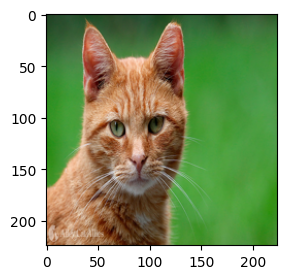

watercolor drawing [RET]
Model generated outputs:
watercolor drawing  [RET]


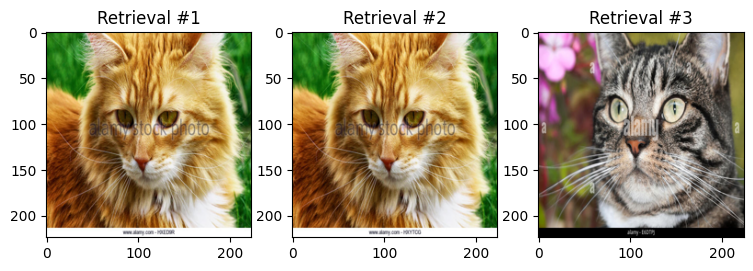

Prompt:


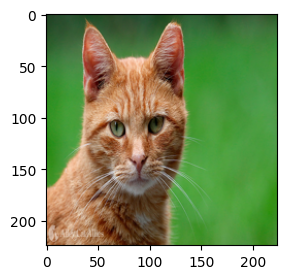

vector icon [RET]
Model generated outputs:
vector icon  [RET]


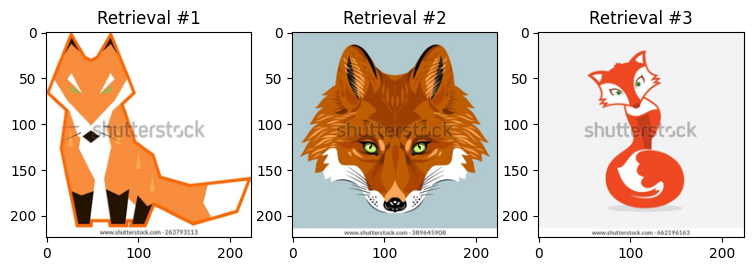

In [ ]:
# Load an image of a cat.
inp_image = utils.get_image_from_url('https://www.alleycat.org/wp-content/uploads/2019/03/FELV-cat.jpg')

# Get FROMAGe to retrieve images of cats in other styles.
for inp_text in ['watercolor drawing [RET]', 'vector icon [RET]']:
    prompt = [inp_image, inp_text]
    print('Prompt:')
    display_interleaved_outputs(prompt)
    print('=' * 30)
    model_outputs = model.generate_for_images_and_texts(prompt, max_img_per_ret=3)

    # Display outputs.
    print('Model generated outputs:')
    display_interleaved_outputs(model_outputs, one_img_per_ret=False)

Prompt:


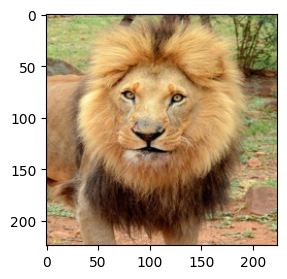

watercolor drawing [RET]
Model generated outputs:
watercolor drawing  [RET]


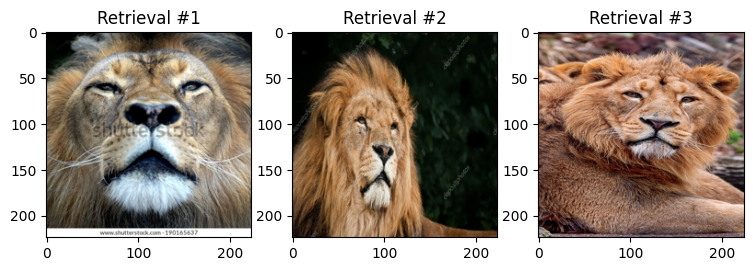

Prompt:


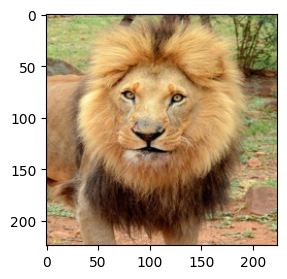

vector icon [RET]
Model generated outputs:
vector icon  [RET]


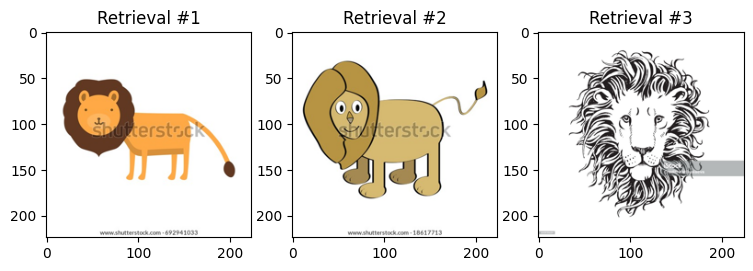

In [ ]:
#Load an image of a lion.
inp_image = utils.get_image_from_url('https://zoogalaktika.ru/assets/img-cache/lion_01.af285398be22fb0d7be885ccf477c831.jpg')

# Get FROMAGe to retrieve images of lions in other styles.
for inp_text in ['watercolor drawing [RET]', 'vector icon [RET]']:
    prompt = [inp_image, inp_text]
    print('Prompt:')
    display_interleaved_outputs(prompt)
    print('=' * 30)
    model_outputs = model.generate_for_images_and_texts(prompt, max_img_per_ret=3)

    # Display outputs.
    print('Model generated outputs:')
    display_interleaved_outputs(model_outputs, one_img_per_ret=False)

Prompt:


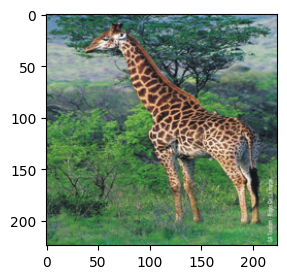

watercolor drawing [RET]
Model generated outputs:
watercolor drawing  [RET]


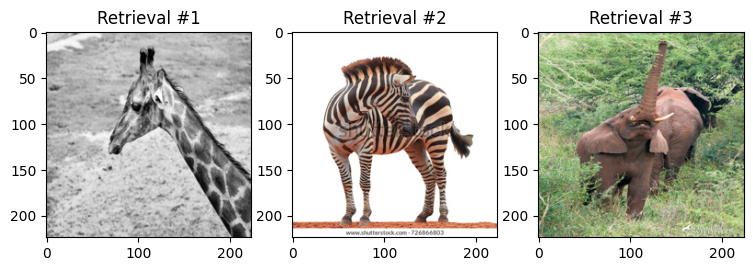

Prompt:


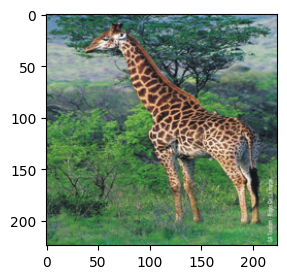

vector icon [RET]
Model generated outputs:
vector icon  [RET]


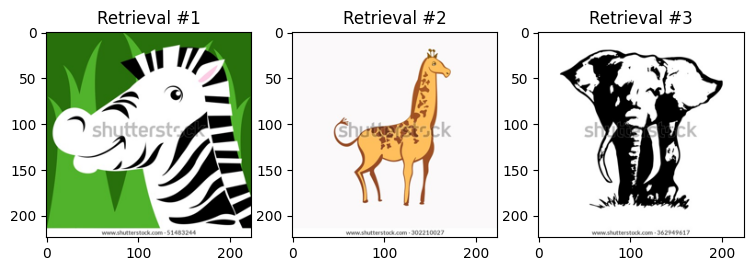

In [ ]:
#Load an image of a giraffe.
inp_image = utils.get_image_from_url('https://mirzoyanvram.files.wordpress.com/2018/09/giraff10.jpg')

# Get FROMAGe to retrieve images of giraffs in other styles.
for inp_text in ['watercolor drawing [RET]', 'vector icon [RET]']:
    prompt = [inp_image, inp_text]
    print('Prompt:')
    display_interleaved_outputs(prompt)
    print('=' * 30)
    model_outputs = model.generate_for_images_and_texts(prompt, max_img_per_ret=3)

    # Display outputs.
    print('Model generated outputs:')
    display_interleaved_outputs(model_outputs, one_img_per_ret=False)

### Multi-Modal Dialogue Examples

Our model can process image and text inputs and return image and text outputs. Here are some examples.

#### Example #1: Beaver Conversation (text inputs, image-and-text outputs)

We can provide text-only inputs to FROMAGe for it to generate image-and-text outputs. This block of code reproduces the beaver example in Fig. 3 of our paper. The text and image outputs starting with "FROMAGe:" are generated by the model.

Input:     I am thinking of an animal. It is red and furry, and has a tail. What is it?
FROMAGe:   [RET]


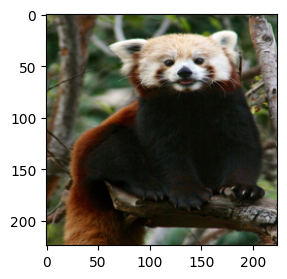

Input:     No, the animal I am thinking of lives in the forest.
FROMAGe:   [RET]


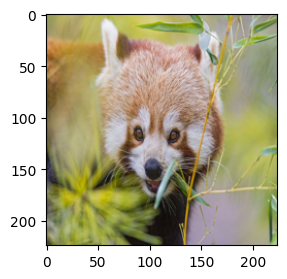

Input:     That's right, what do foxes look like?
FROMAGe:   [RET]


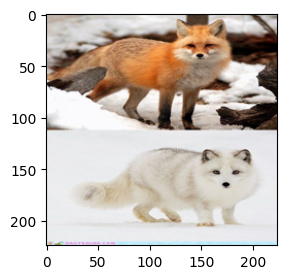

Input:     Show me an illustration of a fox
FROMAGe:   [RET]


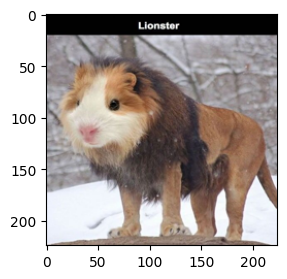

Input:     Yes, what about a pencil drawing of one?
FROMAGe:   [RET]


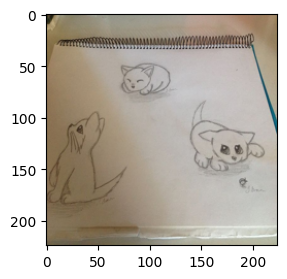

Input:     What about a photo of one?
FROMAGe:   [RET]


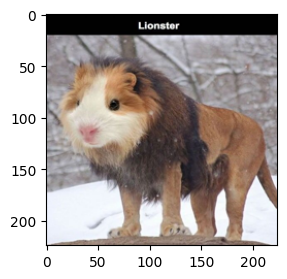

In [ ]:
ret_scale_factor = 5.3  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.

# These will be sequentially fed into the model.
# Update these to use your own prompts!
input_prompts = [
    "I am thinking of an animal. It is red and furry, and has a tail. What is it?",  # Initial prompt.
    "No, the animal I am thinking of lives in the forest.",  # Second prompt, after seeing the model output "A squirrel.".
    "That's right, what do foxes look like?",
    "Show me an illustration of a fox",
    "Yes, what about a pencil drawing of one?",
    "What about a photo of one?",
]


# ==============================================
# Code below this should not need to be edited.
# ==============================================
input_context = []
all_outputs = []
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=1)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'

    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

#### Example #2: 1950s Cars (image-text inputs, image-text outputs)

We can also pass in image-and-text inputs, and receive image-and-text outputs. The following block of code reproduces the car example in Fig. 8 of our paper, which takes in an input image and question, and ends with FROMAGe retrieving new images of cars.

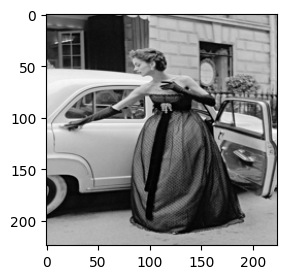

Input:     What is this image?
FROMAGe:   This is a photo of a woman in a car.
Input:     Is the image in color?
FROMAGe:   No, it is black and white.
Input:     When do you think it was taken?
FROMAGe:   The image was taken in the 1950s.
Input:     Do you know what kind of car it is?
FROMAGe:   It is a vintage car.
Input:     Show me more photos of the woman in vintage dresses
FROMAGe:   Here is a photo of a woman in a vintage dress.


In [ ]:
ret_scale_factor = 1.15  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = utils.get_image_from_url(
    'https://i.pinimg.com/736x/d3/8c/21/d38c21ca670ce0be2d01c301b1f0e7d3--vintage-dior-vintage-dresses.jpg')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this image?",
    "Is the image in color?",
    "When do you think it was taken?",
    "Do you know what kind of car it is?",
    "Show me more photos of the woman in vintage dresses"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'

    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

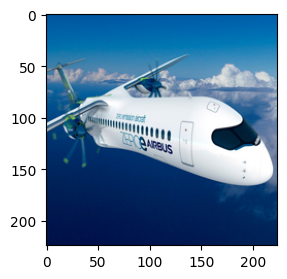

Input:     What is this image?
FROMAGe:   This is a rendering of a new aircraft that is being designed by.
Input:     Is the image in color?
FROMAGe:   No, the image is in black and white.
Input:     When do you think it was taken?
FROMAGe:   The image was taken in the year. [RET]


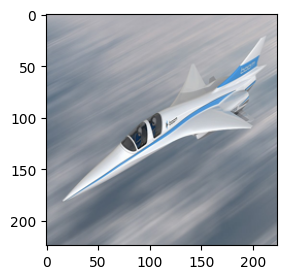

 [RET]


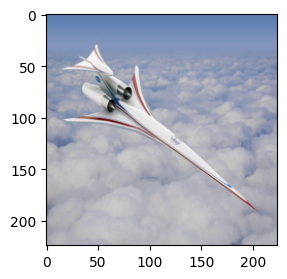

 [RET]


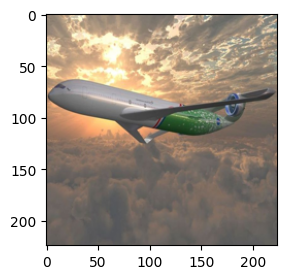

Input:     Do you know what kind of an avion it is?
FROMAGe:   The aircraft is a single - engine turboprop.
Input:     Show me more photos of other avions
FROMAGe:   You can see more photos of other aircraft on the website. [RET]


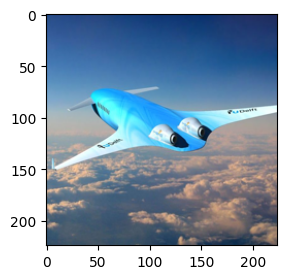

 [RET]


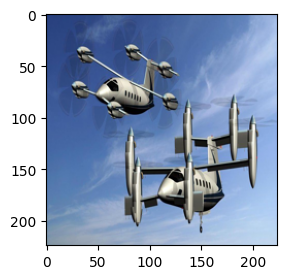

 [RET]


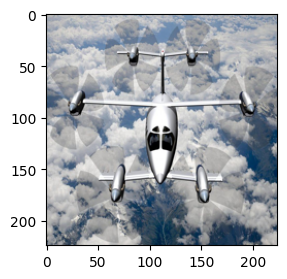

In [ ]:
ret_scale_factor = 1.15  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = utils.get_image_from_url(
    'https://www.interfax.ru/ftproot/textphotos/2020/09/21/a700.jpg')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this image?",
    "Is the image in color?",
    "When do you think it was taken?",
    "Do you know what kind of an avion it is?",
    "Show me more photos of other avions"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'

    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

#### Example #3: Leather Sofa (image-text inputs, image-text outputs)

The following is another example of image-and-text inputs with image-and-text outputs.

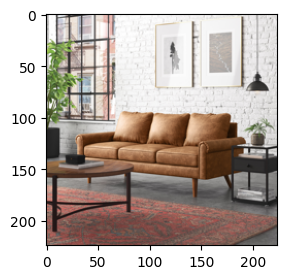

Input:     What is this?
FROMAGe:   This is a sofa that is made of leather.
Input:     Where would this look good in?
FROMAGe:   This sofa would look good in a living room or a bedroom. [RET]


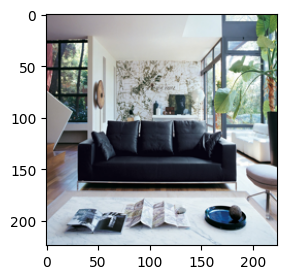

 [RET]


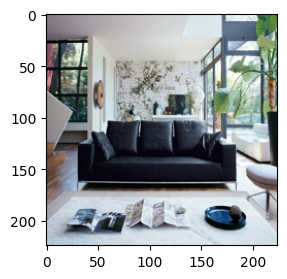

 [RET]


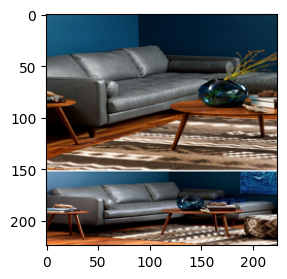

In [ ]:
ret_scale_factor = 1.0  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = utils.get_image_from_url(
    'https://secure.img1-cg.wfcdn.com/im/06305386/compr-r85/1695/169530576/ainsley-736-vegan-leather-sofa.jpg')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this?",
    "Where would this look good in?"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'

    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)

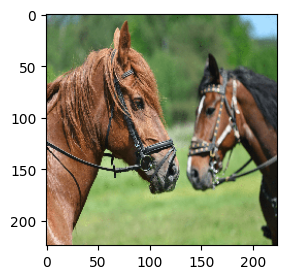

Input:     What is this?
FROMAGe:   Horses and mules are the most common animals used in the show. [RET]


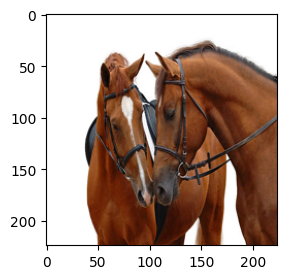

 a horse and a mule. [RET]


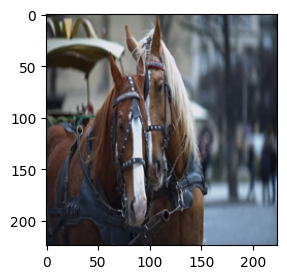

 a horse and a mule. [RET]


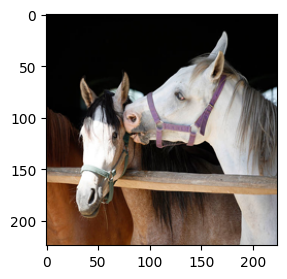

Input:     Where it is sitting?
FROMAGe:   Horses and mules are usually ridden in the show. [RET]


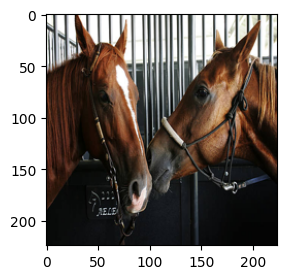

 [RET]


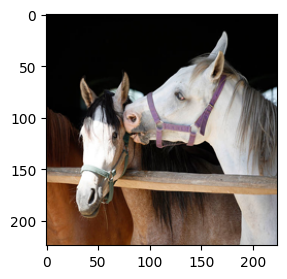

 [RET]


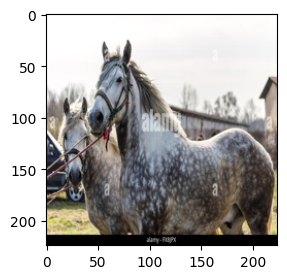

In [ ]:
ret_scale_factor = 1.0  # Increase this hyperparameter to upweight the probability of FROMAGe returning an image.
# Pick a photo.
inp_image = utils.get_image_from_url(
    'https://horseka.ru/wp-content/uploads/2023/01/dogogie.png')
# These will be sequentially fed into the model.
input_prompts = [
    "What is this?",
    "Where it is sitting?"
]

input_context = [inp_image]  # Used for conditioning on images.

# ==============================================
# Code below this should not need to be edited.
# ==============================================
all_outputs = copy.copy(input_context)
text = ''
for p in input_prompts:
    # Add Q+A prefixes for prompting. This is helpful for generating dialogue.
    text += 'Q: ' + p + '\nA:'
    # Concatenate image and text.
    model_prompt = input_context + [text]
    model_outputs = model.generate_for_images_and_texts(
        model_prompt, num_words=32, ret_scale_factor=ret_scale_factor, max_num_rets=3)
    text += ' '.join([s for s in model_outputs if type(s) == str]) + '\n'

    # Format outputs.
    if type(model_outputs[0]) == str:
        model_outputs[0] = 'FROMAGe:  ' + model_outputs[0]
    else:
        # Image output
        model_outputs = ['FROMAGe:  '] + model_outputs[0]
    all_outputs.append('Input:     ' + p)
    all_outputs.extend(model_outputs)

display_interleaved_outputs(all_outputs)